# Read Data

In [ ]:
!unzip "/content/drive/MyDrive/Words_Contradictory/train.csv.zip"

Archive:  /content/drive/MyDrive/Words_Contradictory/train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")

In [ ]:
df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


# Language Transalation

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
from transformers import MarianMTModel, AutoTokenizer

In [ ]:
def translate(sample_text,src,trg):
    model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # sample_text = "où est l'arrêt de bus ?"
    batch = tokenizer([sample_text], return_tensors="pt")

    generated_ids = model.generate(**batch)
    translated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return translated_text

In [ ]:
# EXAMPLE
input_text = "kitu kilitokea"
target_language = 'en'
src_language = 'swc'
translated_text = translate(input_text,src_language ,target_language)
print(translated_text)

Something happened


In [ ]:
for i in df[:1000].index:
  if(df['lang_abv'][i]=='el'):
    df.loc[i,'premise'] = translate(df.loc[i,'premise'],'grk','en')
    df.loc[i,'hypothesis'] = translate(df.loc[i,'hypothesis'],'grk','en')
    df.loc[i,'lang_abv'] = 'en'
  if(df['lang_abv'][i]=='sw'):
    df.loc[i,'premise'] = translate(df.loc[i,'premise'],'swc','en')
    df.loc[i,'hypothesis'] = translate(df.loc[i,'hypothesis'],'swc','en')
    df.loc[i,'lang_abv'] = 'en'
  if(df['lang_abv'][i]!="en"):
    df.loc[i,'premise'] = translate(df.loc[i,'premise'],df.loc[i,'lang_abv'],'en')
    df.loc[i,'hypothesis'] = translate(df.loc[i,'hypothesis'],df.loc[i,'lang_abv'],'en')
    df.loc[i,'lang_abv'] = 'en'
  # if(i%1000==0):
  #   print(i)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transforme

In [ ]:
print(df[:1000]['premise'].map(lambda x: len(x.split())).max())
print(df[:1000]['hypothesis'].map(lambda x: len(x.split())).max())

256
34


# Using Manhattan LSTM Model / Siamese Recurrent Architectures

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense,LSTM,Bidirectional,Lambda,Input
from keras.models import Model

In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

sentence = Input(shape=(256,50))
phrase = Input(shape=(34,50))

sentence_layer1 = Bidirectional(LSTM(256,return_sequences=True))(sentence)
sentence_layer2 = Bidirectional(LSTM(34))(sentence_layer1)

phrase_layer1 = Bidirectional(LSTM(34,return_sequences=True))(phrase)
phrase_layer2 = Bidirectional(LSTM(34,))(phrase_layer1)

relation_layer = Lambda(euclidean_distance)([sentence_layer2,phrase_layer2])
classification_layer1 = Dense(3,activation="sigmoid")(relation_layer)
classification_layer2 = Dense(3,activation="sigmoid")(classification_layer1)

model = Model(inputs=[sentence,phrase],outputs=[classification_layer2])
model.compile(loss="categorical_crossentropy",optimizer="adam")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 50)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 34, 50)]     0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 256, 512)    628736      ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 34, 68)      23120       ['input_4[0][0]']          

# Training on first 1000 values - Euclidean Distance

In [ ]:
import numpy as np
import re

f = open("/content/drive/MyDrive/Image_captioning/glove.6B.50d.txt" , encoding='utf8')
embeddings = {}
for line in f:
  values = line.split()
  embeddings[values[0]] = np.array(values[1:],dtype='float')

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def conversion(text,size):
  text = re.sub("[^a-z]+"," ",text)
  # print(len(text.split()))
  cnt = 0
  arr = np.zeros((size,50))
  for i in text.lower().split():
    if (i in embeddings.keys() and i not in stopwords):
      arr[cnt] = embeddings[i]
      cnt+=1
  return arr

In [ ]:
sentence_arr = []
phrase_arr = []
for i in range(1000):
  # print(i)
  sentence_arr.append(conversion(df.loc[i,'premise'],256))
  phrase_arr.append(conversion(df.loc[i,'hypothesis'],34))

sentence_arr = np.array(sentence_arr)
phrase_arr = np.array(phrase_arr)

In [ ]:
phrase_arr.shape

(1000, 34, 50)

In [ ]:
labels = df[:1000]['label'].values

In [ ]:
labels

In [ ]:
label = np.zeros((1000,3))

In [ ]:
for i in range(1000):
  label[i][labels[i]] = 1

In [ ]:
label

In [ ]:
for epoch in range(50):
  model.fit([sentence_arr,phrase_arr],label,shuffle=True)

32/32 [==============================] - 57s 2s/step - loss: 0.7914


In [ ]:
ouput = np.argmax(model.predict([sentence_arr,phrase_arr]),axis=1)

32/32 [==============================] - 15s 400ms/step


In [ ]:
count = 0
for i in range(1000):
  if(ouput[i]==labels[i]):
    count+=1
print(count)

691


In [ ]:
df[:1000].to_csv("/content/drive/MyDrive/Words_Contradictory/first1000.csv",index=False)

# Manhattan Distance

In [ ]:
import tensorflow as tf

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
np.random.rand(2,2)

array([[0.49352126, 0.45205273],
       [0.55182458, 0.29188925]])

In [ ]:
import numpy as np
x,y = np.random.rand(3,50),np.random.rand(3,50)
# print(x,y)
# print(x-y)
sum_sq = tf.math.reduce_sum((x-y),axis=1)
print(sum_sq)
# print(tf.keras.backend.epsilon())
# print(tf.math.maximum(sum_sq,tf.keras.backend.epsilon()))
# print(tf.math.sqrt(tf.math.maximum(sum_sq, tf.keras.backend.epsilon())))

tf.Tensor([1.67622717 2.10910607 2.05202652], shape=(3,), dtype=float64)


# Testing with Manhattan Distance

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense,LSTM,Bidirectional,Lambda,Input
from keras.models import Model

In [ ]:
def manhattan_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum((x - y), axis=1, keepdims=True)
    return sum_square

sentence = Input(shape=(256,50))
phrase = Input(shape=(34,50))

sentence_layer1 = Bidirectional(LSTM(256,return_sequences=True))(sentence)
sentence_layer2 = Bidirectional(LSTM(34))(sentence_layer1)

phrase_layer1 = Bidirectional(LSTM(34,return_sequences=True))(phrase)
phrase_layer2 = Bidirectional(LSTM(34,))(phrase_layer1)

relation_layer = Lambda(manhattan_distance)([sentence_layer2,phrase_layer2])
classification_layer1 = Dense(3,activation="sigmoid")(relation_layer)
classification_layer2 = Dense(3,activation="sigmoid")(classification_layer1)

model = Model(inputs=[sentence,phrase],outputs=[classification_layer2])
model.compile(loss="categorical_crossentropy",optimizer="adam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 50)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 34, 50)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 256, 512)     628736      ['input_1[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 34, 68)      23120       ['input_2[0][0]']                
 )                                                                                            

In [ ]:
import numpy as np
import re

f = open("/content/drive/MyDrive/Image_captioning/glove.6B.50d.txt" , encoding='utf8')
embeddings = {}
for line in f:
  values = line.split()
  embeddings[values[0]] = np.array(values[1:],dtype='float')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Words_Contradictory/first1000.csv")

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def conversion(text,size):
  text = re.sub("[^a-z]+"," ",text)
  # print(len(text.split()))
  cnt = 0
  arr = np.zeros((size,50))
  for i in text.lower().split():
    if (i in embeddings.keys() and i not in stopwords):
      arr[cnt] = embeddings[i]
      cnt+=1
  return arr

In [ ]:
sentence_arr = []
phrase_arr = []
for i in range(1000):
  # print(i)
  sentence_arr.append(conversion(df.loc[i,'premise'],256))
  phrase_arr.append(conversion(df.loc[i,'hypothesis'],34))

sentence_arr = np.array(sentence_arr)
phrase_arr = np.array(phrase_arr)

In [ ]:
labels = df['label'].values
label = np.zeros((1000,3))
for i in range(1000):
  label[i][labels[i]] = 1

In [ ]:
for epoch in range(10):
  model.fit([sentence_arr,phrase_arr],label,shuffle=True)

32/32 [==============================] - 50s 2s/step - loss: 0.9595


In [ ]:
ouput = np.argmax(model.predict([sentence_arr,phrase_arr]),axis=1)
count = 0
for i in range(1000):
  if(ouput[i]==labels[i]):
    count+=1
print(count)

32/32 [==============================] - 14s 383ms/step
564


# Using cosine_similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
print(x,y)
cosine_similarity(x,y)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 256, 50)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 34, 50)]     0           []                               
                                                                                                  
 bidirectional_48 (Bidirectiona  (None, 256, 512)    628736      ['input_25[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_50 (Bidirectiona  (None, 34, 68)      23120       ['input_26[0][0]']         

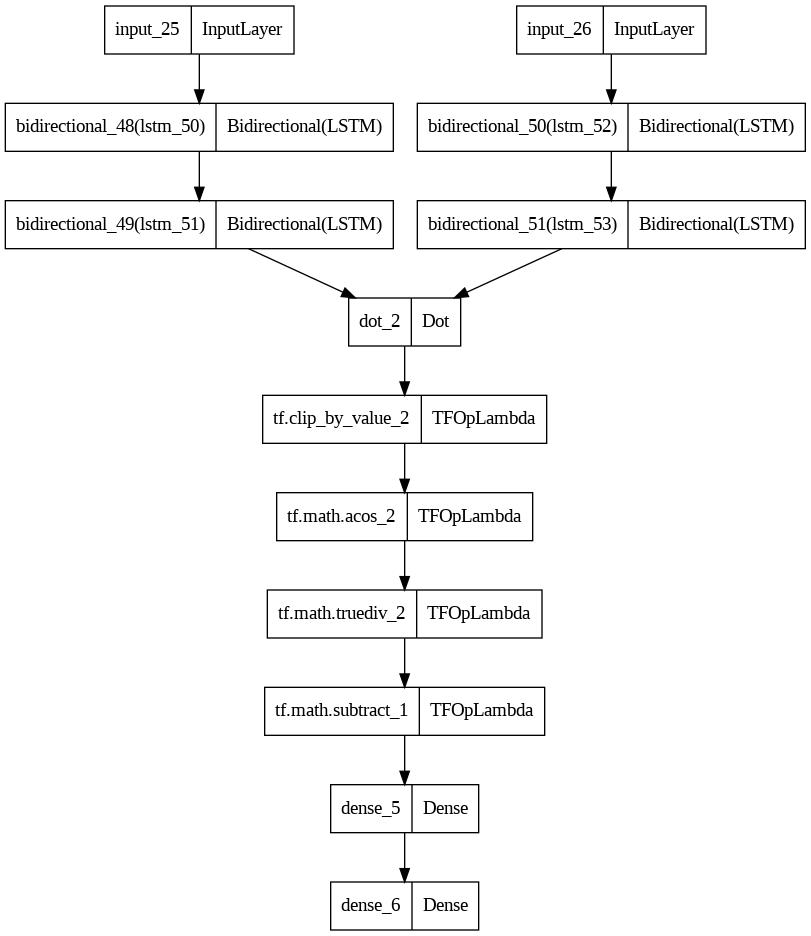

In [ ]:
def cos_similarity(vects):
    x, y = vects
    return tf.keras.losses.cosine_similarity(x,y)

sentence = Input(shape=(256,50))
phrase = Input(shape=(34,50))

sentence_layer1 = Bidirectional(LSTM(256,return_sequences=True))(sentence)
sentence_layer2 = Bidirectional(LSTM(34))(sentence_layer1)

phrase_layer1 = Bidirectional(LSTM(34,return_sequences=True))(phrase)
phrase_layer2 = Bidirectional(LSTM(34))(phrase_layer1)

cosine_similiarity=tf.keras.layers.Dot(axes=-1,normalize=True)([sentence_layer2,phrase_layer2])
clip_cosine_similarities = tf.clip_by_value(cosine_similiarity, -1.0, 1.0)
import math as m
pi = tf.constant(m.pi,dtype= tf.float32)
cos_distance = 1.0 - (tf.acos(clip_cosine_similarities)/pi)

classification_layer1 = Dense(3,activation="sigmoid")(cos_distance)
classification_layer2 = Dense(3,activation="sigmoid")(classification_layer1)

model2 = Model(inputs=[sentence,phrase],outputs=[classification_layer2])
model2.compile(loss="categorical_crossentropy",optimizer="adam")
model2.summary()
tf.keras.utils.plot_model(model2, to_file='my_model.png')

In [ ]:
for epoch in range(10):
  model2.fit([sentence_arr,phrase_arr],label,shuffle=True)

32/32 [==============================] - 89s 3s/step - loss: 1.0889


In [ ]:
ouput = np.argmax(model2.predict([sentence_arr,phrase_arr]),axis=1)
count = 0
for i in range(1000):
  if(ouput[i]==labels[i]):
    count+=1
print(count)

32/32 [==============================] - 25s 630ms/step
483


# Self cosine_similarity

In [ ]:
from scipy.special import y1p_zeros
# def self_cos_sim(vects):
#   x,y = vects
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
x1 = np.random.rand(256,50)
y1 = np.random.rand(34,50)
print(x1)
print(y1)
cosine_similarity(x1,y1).shape

[[0.18607849 0.6976845  0.31325056 ... 0.66992695 0.41219757 0.53435437]
 [0.30541678 0.34894594 0.28786014 ... 0.07676939 0.63740877 0.889535  ]
 [0.23388555 0.77755882 0.27793136 ... 0.14564735 0.81329304 0.81189777]
 ...
 [0.80319111 0.60192609 0.01561117 ... 0.46894275 0.01524252 0.73775235]
 [0.14221172 0.21009684 0.73305741 ... 0.32285299 0.81070035 0.44878069]
 [0.55619501 0.97138808 0.2983376  ... 0.23086445 0.62054379 0.4284841 ]]
[[0.9766528  0.74386091 0.13859594 ... 0.47630271 0.91512604 0.79455317]
 [0.18352004 0.81491167 0.13364468 ... 0.1397714  0.61882007 0.52665344]
 [0.63191278 0.30573643 0.25184959 ... 0.37583878 0.52853012 0.40474424]
 ...
 [0.52393245 0.99158866 0.41556945 ... 0.50191593 0.049062   0.4578746 ]
 [0.32778824 0.15165885 0.89767768 ... 0.91540318 0.62009642 0.21676133]
 [0.13035934 0.6429512  0.62714204 ... 0.51722288 0.08526041 0.93727487]]


(256, 34)

In [ ]:
np.array(tf.Tensor([1,2]))

TypeError: ignored

In [ ]:
tf.Tensor([[1,3],[0,4]],dtype=int,value_index=0)

TypeError: ignored

In [ ]:
# tf.enable_eager_execution()
tf.executing_eagerly()

True

In [ ]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
x = tf.convert_to_tensor([[3,4,5]])
print(type(x))
y = tf.constant([[1,2,3]])
cosine_similarity(x,y)

<class 'tensorflow.python.framework.ops.EagerTensor'>


array([[0.98270763]])

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense,LSTM,Bidirectional,Lambda,Input
from keras.models import Model

def cos_similarity(vects):
    x, y = vects
    x = tf.convert_to_tensor(x)
    print(type(x))
    # tf.config.run_functions_eagerly(True)
    # print(tf.executing_eagerly())
    # if tf.executing_eagerly():
      # print("hrere")
    # x = x.numpy()
    # tf.config.run_functions_eagerly(True)
    # y = y.numpy()
    # print("hrere").
    y = tf.convert_to_tensor(y)
    return cosine_similarity(x,y)

sentence = Input(shape=(256,50))
phrase = Input(shape=(34,50))

sentence_layer1 = Bidirectional(LSTM(256,return_sequences=True))(sentence)
sentence_layer2 = Bidirectional(LSTM(34,return_sequences=True))(sentence_layer1)

phrase_layer1 = Bidirectional(LSTM(34,return_sequences=True))(phrase)
phrase_layer2 = Bidirectional(LSTM(34,return_sequences=True))(phrase_layer1)

# cosine_similiarity=tf.keras.layers.Dot(axes=-1,normalize=True)([sentence_layer2,phrase_layer2])
# clip_cosine_similarities = tf.clip_by_value(cosine_similiarity, -1.0, 1.0)
# import math as m
# pi = tf.constant(m.pi,dtype= tf.float32)
# cos_distance = 1.0 - (tf.acos(clip_cosine_similarities)/pi)

relation_layer = Lambda(cos_similarity)([sentence_layer2,phrase_layer2])

classification_layer = LSTM()
classification_layer1 = Dense(3,activation="sigmoid")(cos_distance)
classification_layer2 = Dense(3,activation="softmax")(classification_layer1)

model2 = Model(inputs=[sentence,phrase],outputs=[classification_layer2])
model2.compile(loss="categorical_crossentropy",optimizer="adam",run_eagerly=True)
model2.summary()
tf.keras.utils.plot_model(model2, to_file='my_model.png')

<class 'tensorflow.python.framework.ops.Tensor'>


NotImplementedError: ignored

# Cosine Similarity with Pytorch Model
As cosine_similarity is not working with Tensorflow in tensorflow function, it only works in eager mode i.e outside the model not within the model

This model is working best as compared to any other models

In [ ]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
  def __init__(self,input_dim_premise,input_dim_hypothesis,hidden_dim,batch_size,max_len_premise,max_len_hypothesis,output_dim=3,num_layers=2,rnn_type='LSTM'):
    super(Net,self).__init__()
    self.input_dim_premise = input_dim_premise
    self.input_dim_hypothesis = input_dim_hypothesis
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    self.num_layers = num_layers
    self.max_len_premise = max_len_premise
    self.max_len_hypothesis = max_len_hypothesis

    self.premise_lstm1 = torch.nn.LSTM(input_size=self.input_dim_premise,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    self.flatten1 = torch.nn.Flatten()
    self.linear_premise = torch.nn.Linear(self.hidden_dim*2*self.max_len_premise,1700)
    self.hypothesis_lstm1 = torch.nn.LSTM(input_size=self.input_dim_hypothesis,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    self.flatten2 = torch.nn.Flatten()
    self.linear_hypothesis = torch.nn.Linear(self.hidden_dim*2*self.max_len_hypothesis,1700)

    self.cosine_similarity = torch.nn.CosineSimilarity(dim=1)

    self.linear1 = torch.nn.Linear(50,16)
    self.linear2 = torch.nn.Linear(16,3)

  def forward(self,input):
    x,y = input
    output1,(hn,cn) = self.premise_lstm1(x)
    output1 = self.flatten1(output1)
    output1 = self.linear_premise(output1)
    output1 = output1.view(256,34,-1)
    output2,(hn,cn) = self.hypothesis_lstm1(y)
    output2 = self.flatten2(output2)
    output2 = self.linear_hypothesis(output2)
    output2 = output2.view(256,34,-1)
    # print(output1.shape)
    # print(output2.shape)
    output = self.cosine_similarity(output1,output2)
    # print(output)
    # print(output.shape)
    output = self.linear1(output)
    output = self.linear2(output)
    return F.softmax(output,dim=1)

In [ ]:
import numpy as np
import re

f = open("/content/drive/MyDrive/Image_captioning/glove.6B.50d.txt" , encoding='utf8')
embeddings = {}
for line in f:
  values = line.split()
  embeddings[values[0]] = np.array(values[1:],dtype='float')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Words_Contradictory/first1000.csv")

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def conversion(text,size):
  text = re.sub("[^a-z]+"," ",text)
  cnt = 0
  arr = np.zeros((size,50))
  for i in text.lower().split():
    if (i in embeddings.keys() and i not in stopwords):
      arr[cnt] = embeddings[i]
      cnt+=1
  return arr

In [ ]:
sentence_arr = []
phrase_arr = []
for i in range(1000):
  sentence_arr.append(conversion(df.loc[i,'premise'],256))
  phrase_arr.append(conversion(df.loc[i,'hypothesis'],34))

sentence_arr = torch.Tensor(np.array(sentence_arr))
phrase_arr = torch.Tensor(np.array(phrase_arr))

In [ ]:
labels = df['label'].values
label = np.zeros((1000,3))
for i in range(1000):
  label[i][labels[i]] = 1
label = torch.Tensor(label)

In [ ]:
input_dim_premise = 50
input_dim_hypothesis = 50
hidden_dim = 1
BATCH_SIZE = 256
max_len_premise = 256
max_len_hypothesis = 34
net = Net(input_dim_premise,input_dim_hypothesis,hidden_dim,BATCH_SIZE,max_len_premise,max_len_hypothesis)
import torch.optim as optim
optimizer = optim.Adam(net.parameters())
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
# Training of model
from tqdm import tqdm
EPOCHS = 100
def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0,768,BATCH_SIZE)):
      premise_X = sentence_arr[i:i+BATCH_SIZE]
      hypothesis_X = phrase_arr[i:i+BATCH_SIZE]
      batch_y = label[i:i+BATCH_SIZE]

      optimizer.zero_grad()
      outputs = net((premise_X,hypothesis_X))
      loss = loss_function(outputs,batch_y)
      loss.backward()
      optimizer.step()
    print("loss")
    print(loss)

train(net)

100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


loss
tensor(1.0930, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


loss
tensor(1.0909, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


loss
tensor(1.0880, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


loss
tensor(1.0849, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


loss
tensor(1.0814, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


loss
tensor(1.0787, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


loss
tensor(1.0765, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


loss
tensor(1.0736, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


loss
tensor(1.0704, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


loss
tensor(1.0676, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


loss
tensor(1.0639, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


loss
tensor(1.0609, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


loss
tensor(1.0575, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


loss
tensor(1.0531, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


loss
tensor(1.0484, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


loss
tensor(1.0435, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


loss
tensor(1.0378, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


loss
tensor(1.0313, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


loss
tensor(1.0232, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


loss
tensor(1.0148, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


loss
tensor(1.0101, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


loss
tensor(1.0007, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


loss
tensor(0.9902, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


loss
tensor(0.9886, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


loss
tensor(0.9764, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


loss
tensor(0.9653, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


loss
tensor(0.9567, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


loss
tensor(0.9477, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


loss
tensor(0.9384, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


loss
tensor(0.9269, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


loss
tensor(0.9196, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


loss
tensor(0.9110, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


loss
tensor(0.9070, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


loss
tensor(0.8949, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


loss
tensor(0.8960, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


loss
tensor(0.8836, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


loss
tensor(0.8839, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


loss
tensor(0.8722, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


loss
tensor(0.8649, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


loss
tensor(0.8600, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


loss
tensor(0.8536, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


loss
tensor(0.8536, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


loss
tensor(0.8364, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


loss
tensor(0.8283, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


loss
tensor(0.8190, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


loss
tensor(0.8153, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


loss
tensor(0.8059, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


loss
tensor(0.8024, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


loss
tensor(0.7978, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


loss
tensor(0.7914, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


loss
tensor(0.7923, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


loss
tensor(0.7859, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


loss
tensor(0.7843, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


loss
tensor(0.7725, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


loss
tensor(0.7673, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


loss
tensor(0.7626, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


loss
tensor(0.7581, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


loss
tensor(0.7540, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


loss
tensor(0.7479, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


loss
tensor(0.7462, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


loss
tensor(0.7407, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


loss
tensor(0.7370, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


loss
tensor(0.7325, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


loss
tensor(0.7270, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


loss
tensor(0.7266, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


loss
tensor(0.7208, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


loss
tensor(0.7206, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


loss
tensor(0.7168, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


loss
tensor(0.7191, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


loss
tensor(0.7126, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


loss
tensor(0.7157, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


loss
tensor(0.7107, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


loss
tensor(0.7028, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


loss
tensor(0.7066, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


loss
tensor(0.6986, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


loss
tensor(0.6939, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


loss
tensor(0.6947, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


loss
tensor(0.6912, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


loss
tensor(0.6875, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


loss
tensor(0.6828, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


loss
tensor(0.6820, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


loss
tensor(0.6832, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


loss
tensor(0.6806, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


loss
tensor(0.6746, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


loss
tensor(0.6782, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


loss
tensor(0.6746, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


loss
tensor(0.6726, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


loss
tensor(0.6712, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


loss
tensor(0.6703, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


loss
tensor(0.6761, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


loss
tensor(0.6830, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


loss
tensor(0.6766, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


loss
tensor(0.6704, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


loss
tensor(0.6722, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


loss
tensor(0.6704, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


loss
tensor(0.6687, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


loss
tensor(0.6685, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


loss
tensor(0.6671, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


loss
tensor(0.6640, grad_fn=<DivBackward1>)


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

loss
tensor(0.6668, grad_fn=<DivBackward1>)


In [ ]:
o = torch.argmax(net((sentence_arr[:256],phrase_arr[:256])),dim=1)
actual = labels[:256]
# print(o,actual)
count = 0
for i in range(256):
  if(actual[i]==int(o[i])):
    count += 1

count

230

In [ ]:
# rnn = torch.nn.LSTM(10, 1, 2,bidirectional=True)
# input = torch.randn(3,2,10)
h0 = torch.randn(3, 20,50)
c0 = torch.randn(3, 20,50)
# output, (hn, cn) = rnn(input)

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1)
cos(h0,c0).shape

torch.Size([3, 50])

In [ ]:
import numpy as np
torch.Tensor(np.array([1,2,3]))

tensor([1., 2., 3.])

In [ ]:
print(output.shape)

torch.Size([3, 2, 2])


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters())
loss_function = torch.nn.MSELoss()
net([h0,c0])

tensor([[ 0.4246, -0.9510,  0.9605,  0.3505, -0.9721,  0.7973, -0.9972, -0.9531,
         -0.9766,  0.8721,  0.2618, -0.9944,  0.9967,  0.9657, -0.4256,  0.0679,
          0.6991,  0.8367,  0.9538, -0.9746],
        [-0.9745, -0.5670,  0.9270,  0.9330, -0.9681, -0.9085,  0.9293,  0.9471,
         -0.9798,  0.0450,  0.9044,  0.7210,  0.9646,  0.9480, -0.9930,  0.7424,
          0.0409, -0.9332,  0.9276,  0.1208]], grad_fn=<SumBackward1>)
torch.Size([2, 20])


tensor([[0.4601, 0.3222, 0.2177],
        [0.4695, 0.2302, 0.3003]], grad_fn=<SoftmaxBackward0>)

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0)
cos(h0,c0).shape

torch.Size([3, 20])

In [ ]:
print(h0)

tensor([[[-1.3293e+00,  7.9359e-01, -2.1275e-01, -5.7459e-01, -7.2579e-01,
          -1.9114e+00, -1.4571e+00,  2.1270e+00, -1.8701e-01,  1.2643e+00,
          -1.8888e-01, -1.0048e+00,  1.1836e+00,  2.0537e-01,  1.8334e-01,
           1.5464e-01,  1.4624e+00,  5.7105e-02, -4.8022e-01,  1.0976e+00],
         [-6.9334e-02, -1.6086e+00, -1.0037e+00,  5.8652e-01,  6.9692e-01,
           4.4925e-01,  1.0251e+00,  6.4821e-01, -8.7344e-01,  3.3742e-01,
           5.6446e-01,  1.1400e-01, -4.9494e-01,  1.7727e+00,  1.7331e+00,
          -8.1904e-01, -6.7020e-01,  9.6621e-02, -7.6106e-01, -1.1748e-01],
         [-6.7279e-01, -8.3195e-01,  1.7065e+00, -7.6547e-02, -1.7017e+00,
          -2.7178e-01,  1.1281e+00, -1.1979e+00,  1.1579e+00, -3.7273e-01,
          -1.2677e+00,  6.4487e-01, -1.0126e+00, -1.1419e+00, -1.0197e+00,
           1.8601e+00,  1.5431e+00,  1.4491e+00, -2.4353e+00, -1.6244e-01]],

        [[-9.3927e-02,  1.4217e+00,  2.8794e-02,  2.5088e+00,  2.7099e-02,
          -1.5372e+0

In [ ]:
print(output.shape)

torch.Size([3, 2])


In [ ]:
print(cn)

tensor([[[-0.3067,  0.4054, -0.5612,  0.2602, -0.0323, -0.1569, -0.0357,
          -0.1210, -0.1931, -0.1883,  0.2207, -0.3720, -0.5776, -0.4888,
           0.3562,  0.5276,  0.1231, -0.2518,  0.3787,  0.1856],
         [-0.1329,  0.0852,  0.0602,  0.1715, -0.1430, -0.0964,  0.2379,
           0.1455, -0.2375,  0.0437,  0.3072, -0.1951, -0.3551, -0.1301,
           0.1457,  0.0894, -0.6101,  0.0541,  0.0816, -0.0776],
         [-0.4573,  0.2810,  0.0535,  0.2536, -0.1182, -0.1649,  0.1384,
           0.0710, -0.2969,  0.2371,  0.0455, -0.4934, -0.2472, -0.4202,
           0.3507,  0.1577, -0.7082,  0.0359, -0.0101, -0.2626]],

        [[-0.2934, -0.2581, -0.1785, -0.2712, -0.0083,  0.1657, -0.0954,
           0.2218,  0.2112,  0.2622,  0.2124, -0.2000, -0.0073, -0.3305,
          -0.3098,  0.1958, -0.2410, -0.1030,  0.0996, -0.1983],
         [-0.2197, -0.2608, -0.2379, -0.2183,  0.0495,  0.1613, -0.0332,
           0.1753,  0.2219,  0.2128,  0.3486, -0.3078, -0.0077, -0.3114,
        

# Self created Cosine_similarity with Pytorch Model

In [ ]:
import torch
import torch.nn.functional as F

def self_cosine_similarity(batch_size,max_len_premise,max_len_hypothesis,premise,hypothesis):
  ans = torch.zeros([batch_size,max_len_premise])
  for batch in range(batch_size):
    for i in range(max_len_premise):
      temp = 10e9
      for j in range(max_len_hypothesis):
        temp += torch.sqrt(torch.sum((premise[batch][i]-hypothesis[batch][j])**2))
      ans[batch][i] = temp
  return torch.Tensor(ans)

class Net(torch.nn.Module):

  def __init__(self,input_dim_premise,input_dim_hypothesis,hidden_dim,batch_size,max_len_premise,max_len_hypothesis,output_dim=3,num_layers=2,rnn_type='LSTM'):
    super(Net,self).__init__()
    self.input_dim_premise = input_dim_premise
    self.input_dim_hypothesis = input_dim_hypothesis
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    self.num_layers = num_layers
    self.max_len_premise = max_len_premise
    self.max_len_hypothesis = max_len_hypothesis

    self.premise_lstm1 = torch.nn.LSTM(input_size=self.input_dim_premise,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    # self.flatten1 = torch.nn.Flatten()
    # self.linear_premise = torch.nn.Linear(self.hidden_dim*2*self.max_len_premise,1700)
    self.hypothesis_lstm1 = torch.nn.LSTM(input_size=self.input_dim_hypothesis,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    # self.flatten2 = torch.nn.Flatten()
    # self.linear_hypothesis = torch.nn.Linear(self.hidden_dim*2*self.max_len_hypothesis,1700)

    self.cosine_similarity = self_cosine_similarity

    self.linear1 = torch.nn.Linear(self.max_len_premise,16)
    self.linear2 = torch.nn.Linear(16,output_dim)


  def forward(self,input):
    x,y = input
    output1,(hn,cn) = self.premise_lstm1(x)
    # output1 = self.flatten1(output1)
    # output1 = self.linear_premise(output1)
    # output1 = output1.view(256,34,-1)
    output2,(hn,cn) = self.hypothesis_lstm1(y)
    # output2 = self.flatten2(output2)
    # output2 = self.linear_hypothesis(output2)
    # output2 = output2.view(256,34,-1)
    print(output1.shape)
    print(output2.shape)
    output = self.cosine_similarity(self.batch_size,self.max_len_premise,self.max_len_hypothesis,output1,output2)
    print(output.shape)
    print(output.shape)
    output = self.linear1(output)
    output = self.linear2(output)
    return F.softmax(output,dim=1)

In [ ]:
import torch
import torch.nn.functional as F

def self_cosine_similarity(premise,hypothesis):
    return torch.matmul(premise,torch.transpose(hypothesis,1,2))

class Net(torch.nn.Module):

  def __init__(self,input_dim_premise,input_dim_hypothesis,hidden_dim,batch_size,max_len_premise,max_len_hypothesis,output_dim=3,num_layers=2,rnn_type='LSTM'):
    super(Net,self).__init__()
    self.input_dim_premise = input_dim_premise
    self.input_dim_hypothesis = input_dim_hypothesis
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    self.num_layers = num_layers
    self.max_len_premise = max_len_premise
    self.max_len_hypothesis = max_len_hypothesis

    self.premise_lstm1 = torch.nn.LSTM(input_size=self.input_dim_premise,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    # self.flatten1 = torch.nn.Flatten()
    # self.linear_premise = torch.nn.Linear(self.hidden_dim*2*self.max_len_premise,1700)
    self.hypothesis_lstm1 = torch.nn.LSTM(input_size=self.input_dim_hypothesis,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    # self.flatten2 = torch.nn.Flatten()
    # self.linear_hypothesis = torch.nn.Linear(self.hidden_dim*2*self.max_len_hypothesis,1700)

    self.cosine_similarity = self_cosine_similarity
    self.flatten = torch.nn.Flatten()

    self.linear1 = torch.nn.Linear(self.max_len_premise*self.max_len_hypothesis,1024)
    self.linear2 = torch.nn.Linear(1024,256)
    self.linear3 = torch.nn.Linear(256,16)
    self.linear4 = torch.nn.Linear(16,output_dim)


  def forward(self,input):
    x,y = input
    output1,(hn,cn) = self.premise_lstm1(x)
    # output1 = self.flatten1(output1)
    # output1 = self.linear_premise(output1)
    # output1 = output1.view(256,34,-1)
    output2,(hn,cn) = self.hypothesis_lstm1(y)
    # output2 = self.flatten2(output2)
    # output2 = self.linear_hypothesis(output2)
    # output2 = output2.view(256,34,-1)
    # print(output1.shape)
    # print(output2.shape)
    output = self.cosine_similarity(output1,output2)
    # print(output.shape)
    output = self.flatten(output)
    output = self.linear1(output)
    output = self.linear2(output)
    output = self.linear3(output)
    output = self.linear4(output)
    return F.softmax(output,dim=1)

In [ ]:
input_dim_premise = 50
input_dim_hypothesis = 50
hidden_dim = 50
BATCH_SIZE = 64
max_len_premise = 256
max_len_hypothesis = 34
net = Net(input_dim_premise,input_dim_hypothesis,hidden_dim,BATCH_SIZE,max_len_premise,max_len_hypothesis)
import torch.optim as optim
optimizer = optim.Adam(net.parameters())
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
# import torch
# ans = torch.zeros([256])
# x = torch.rand((256,50))
# y = torch.rand((32,50))
# for i in range(256):
#   temp = 10e9
#   for j in range(32):
#     temp = min(temp,torch.sqrt(torch.sum((x[i]-y[j])**2)))
#   ans[i] = temp
# ans

tensor([2.3293, 2.2802, 2.3540, 2.6087, 2.4353, 2.2188, 2.5300, 2.5559, 2.3604,
        2.4522, 2.4201, 2.4417, 2.3292, 2.4403, 2.2795, 2.4722, 2.6526, 2.3223,
        2.1618, 2.5402, 2.4497, 2.5292, 2.3671, 2.5779, 2.3888, 2.4915, 2.5443,
        2.2889, 2.3285, 2.6297, 2.6677, 2.5748, 2.4453, 2.4278, 2.0575, 2.3764,
        2.5263, 2.5031, 2.4440, 2.3124, 2.5699, 2.3495, 2.4020, 2.3966, 2.3758,
        2.3439, 2.3165, 2.4752, 2.2464, 2.2616, 2.4403, 2.4243, 2.4205, 2.2645,
        2.4121, 2.5868, 2.4411, 2.4731, 2.4209, 2.3963, 2.5203, 2.4473, 2.1692,
        2.6918, 2.4780, 2.4240, 2.3914, 2.3015, 2.6276, 2.3991, 2.3060, 2.1829,
        2.6736, 2.2388, 2.3779, 2.3229, 2.4025, 2.3126, 2.3543, 2.3521, 2.2660,
        2.3448, 2.2872, 2.3341, 2.4212, 2.4488, 2.5805, 2.3816, 2.3570, 2.3986,
        2.3120, 2.3704, 2.2871, 2.3545, 2.5383, 2.5733, 2.4216, 2.4874, 2.4657,
        2.1790, 2.0988, 2.6087, 2.3436, 2.3879, 2.4104, 2.5173, 2.3065, 2.4429,
        2.5645, 2.4092, 2.4747, 2.3330, 

In [ ]:
import numpy as np
import re

f = open("/content/drive/MyDrive/Image_captioning/glove.6B.50d.txt" , encoding='utf8')
embeddings = {}
for line in f:
  values = line.split()
  embeddings[values[0]] = np.array(values[1:],dtype='float')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Words_Contradictory/first1000.csv")

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def conversion(text,size):
  text = re.sub("[^a-z]+"," ",text)
  cnt = 0
  arr = np.zeros((size,50))
  for i in text.lower().split():
    if (i in embeddings.keys() and i not in stopwords):
      arr[cnt] = embeddings[i]
      cnt+=1
  return arr

In [ ]:
sentence_arr = []
phrase_arr = []
for i in range(1000):
  sentence_arr.append(conversion(df.loc[i,'premise'],256))
  phrase_arr.append(conversion(df.loc[i,'hypothesis'],34))

sentence_arr = torch.Tensor(np.array(sentence_arr))
phrase_arr = torch.Tensor(np.array(phrase_arr))

In [ ]:
labels = df['label'].values
label = np.zeros((1000,3))
for i in range(1000):
  label[i][labels[i]] = 1
label = torch.Tensor(label)

In [ ]:
# Training of model
from tqdm import tqdm
EPOCHS = 50
def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0,960,BATCH_SIZE)):
      premise_X = sentence_arr[i:i+BATCH_SIZE]
      hypothesis_X = phrase_arr[i:i+BATCH_SIZE]
      batch_y = label[i:i+BATCH_SIZE]

      optimizer.zero_grad()
      outputs = net((premise_X,hypothesis_X))
      loss = loss_function(outputs,batch_y)
      loss.backward()
      optimizer.step()
    print("loss")
    print(loss)
train(net)

100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


loss
tensor(1.1244, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


loss
tensor(1.0957, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


loss
tensor(1.1008, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


loss
tensor(1.1062, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


loss
tensor(1.0993, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


loss
tensor(1.0955, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


loss
tensor(1.0865, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


loss
tensor(1.0798, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


loss
tensor(1.0749, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


loss
tensor(1.0609, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


loss
tensor(1.0212, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


loss
tensor(1.0459, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


loss
tensor(1.0463, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


loss
tensor(1.0439, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


loss
tensor(1.0415, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


loss
tensor(1.0170, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


loss
tensor(1.0251, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


loss
tensor(0.9911, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


loss
tensor(0.9452, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


loss
tensor(0.9807, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


loss
tensor(0.9900, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


loss
tensor(0.9303, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


loss
tensor(0.9926, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


loss
tensor(0.8811, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


loss
tensor(0.8951, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


loss
tensor(0.9470, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


loss
tensor(0.9426, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


loss
tensor(0.9917, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


loss
tensor(0.9302, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


loss
tensor(0.9140, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


loss
tensor(0.9305, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


loss
tensor(0.9112, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


loss
tensor(0.9886, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


loss
tensor(0.8990, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


loss
tensor(0.9499, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:18<00:00,  1.27s/it]


loss
tensor(0.8668, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


loss
tensor(0.8885, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


loss
tensor(0.8281, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


loss
tensor(0.8471, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


loss
tensor(0.8671, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


loss
tensor(1.0579, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


loss
tensor(0.8901, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


loss
tensor(0.9517, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


loss
tensor(1.0481, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


loss
tensor(1.0568, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


loss
tensor(0.9989, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


loss
tensor(0.9592, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


loss
tensor(1.0128, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


loss
tensor(1.0568, grad_fn=<DivBackward1>)


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]

loss
tensor(1.1185, grad_fn=<DivBackward1>)


In [ ]:
o = torch.argmax(net((sentence_arr[:100],phrase_arr[:100])),dim=1)
actual = labels[:100]
count = 0
for i in range(100):
  if(actual[i]==int(o[i])):
    count += 1

count

48

In [ ]:
import torch
x = torch.rand(2,3,3)
y = torch.rand(2,2,3)
print(x)
print(y)
print(torch.transpose(x,1,2))
print(torch.matmul(x,torch.transpose(y)))
print(torch.matmul(x[1],y[1]))


tensor([[[0.7366, 0.7100, 0.8227],
         [0.7312, 0.2860, 0.9533],
         [0.7037, 0.8728, 0.4679]],

        [[0.8211, 0.9719, 0.7598],
         [0.9240, 0.7846, 0.8333],
         [0.2182, 0.9647, 0.4876]]])
tensor([[[0.6390, 0.4374, 0.9597],
         [0.1969, 0.9763, 0.6877]],

        [[0.1529, 0.7324, 0.4357],
         [0.4394, 0.0494, 0.7644]]])
tensor([[[0.7366, 0.7312, 0.7037],
         [0.7100, 0.2860, 0.8728],
         [0.8227, 0.9533, 0.4679]],

        [[0.8211, 0.9240, 0.2182],
         [0.9719, 0.7846, 0.9647],
         [0.7598, 0.8333, 0.4876]]])


TypeError: ignored

# Final Model

In [ ]:
!pip install sentence-transformers

In [ ]:
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

class Net(torch.nn.Module):
  def __init__(self,hidden_dim=50,batch_size=64,embedding_size=384,output_dim=3,num_layers=2,rnn_type='LSTM',model=SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')):
    super(Net,self).__init__()
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    self.num_layers = num_layers
    self.model=model

    self.encode_layer = self.model.encode
    self.premise_lstm1 = torch.nn.LSTM(input_size=embedding_size,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    self.linear_premise = torch.nn.Linear(self.hidden_dim*2,self.hidden_dim)
    self.hypothesis_lstm1 = torch.nn.LSTM(input_size=embedding_size,hidden_size=self.hidden_dim,num_layers=self.num_layers,bidirectional=True,batch_first=True)
    self.linear_hypothesis = torch.nn.Linear(self.hidden_dim*2,self.hidden_dim)

    self.cosine_similarity = torch.nn.CosineSimilarity(dim=1)

    self.linear1 = torch.nn.Linear(1,6)
    self.linear2 = torch.nn.Linear(6,3)

  def forward(self,input):
    x,y = input
    x=self.encode_layer(x)
    output1,(hn,cn) = self.premise_lstm1(torch.Tensor(x))
    output1 = self.linear_premise(output1)

    y=self.encode_layer(y)
    output2,(hn,cn) = self.hypothesis_lstm1(torch.Tensor(y))
    output2 = self.linear_hypothesis(output2)

    output = self.cosine_similarity(output1,output2).view((-1,1))

    print(output.shape)
    output = self.linear1(output)
    output = self.linear2(output)
    return F.softmax(output,dim=1)

In [ ]:
from torchvision import models
from torchsummary import summary

In [ ]:
BATCH_SIZE=64
net = Net()

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7eff8595ac70>

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters())
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
model.encode("Hi this side coder and you are watching sarthak colab trying to develop this code from past seven days and now it's almost done. I am happy I achieved good accuracy and well congratulations to myself").shape

(384,)

In [ ]:
!unzip "/content/drive/MyDrive/Words_Contradictory/train.csv.zip"

Archive:  /content/drive/MyDrive/Words_Contradictory/train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")

In [ ]:
df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [ ]:
premise = df['premise'].values
hypothesis = df['hypothesis'].values
label = df['label'].values

In [ ]:
train_premise = premise[:800]
test_premise = premise[800:1000]
train_hypothesis = hypothesis[:800]
test_hypothesis = hypothesis[800:1000]
train_label = label[:800]
test_label = label[800:1000]

In [ ]:
train_labels = np.zeros((800,3))
for i in range(800):
  train_labels[i][train_label[i]] = 1
train_labels = torch.Tensor(train_labels)
test_labels = np.zeros((200,3))
for i in range(200):
  test_labels[i][test_label[i]] = 1
test_labels = torch.Tensor(test_labels)

In [ ]:
# Training of model
from tqdm import tqdm
EPOCHS = 50
def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0,768,BATCH_SIZE)):
      premise_X = train_premise[i:i+BATCH_SIZE]
      hypothesis_X = train_hypothesis[i:i+BATCH_SIZE]
      batch_y = train_labels[i:i+BATCH_SIZE]

      optimizer.zero_grad()
      outputs = net((premise_X,hypothesis_X))
      loss = loss_function(outputs,batch_y)
      loss.backward()
      optimizer.step()
    print("loss")
    print(loss)
train(net)

  8%|▊         | 1/12 [00:06<01:10,  6.40s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:20<01:51, 11.11s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:25<01:15,  8.40s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:31<00:57,  7.13s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:38<00:50,  7.19s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:43<00:37,  6.31s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:49<00:31,  6.33s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:57<00:27,  6.79s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [01:02<00:19,  6.40s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [01:09<00:13,  6.55s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:14<00:05,  5.89s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:22<00:00,  6.85s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:16,  6.92s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:09,  6.97s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:21<01:03,  7.07s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:26<00:49,  6.24s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:32<00:43,  6.24s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:37<00:36,  6.04s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:42<00:28,  5.68s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:51<00:26,  6.52s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:56<00:18,  6.28s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [01:01<00:11,  5.79s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:08<00:06,  6.05s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:15<00:00,  6.30s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:07<01:24,  7.64s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:15<01:15,  7.51s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:20<01:01,  6.78s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:27<00:52,  6.62s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:32<00:42,  6.11s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:38<00:35,  5.91s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:43<00:29,  5.91s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:50<00:24,  6.00s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:57<00:19,  6.43s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [01:02<00:11,  5.83s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:06<00:05,  5.34s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:14<00:00,  6.22s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:58,  5.35s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:09,  6.98s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:54,  6.11s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:43,  5.50s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:30<00:42,  6.02s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.41s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:38<00:25,  5.11s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:46<00:23,  5.99s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:16,  5.66s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.22s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:02<00:05,  5.53s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:09,  6.34s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:08,  6.89s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:53,  5.94s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:49,  6.18s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:29<00:40,  5.73s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:31,  5.18s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:40<00:27,  5.55s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:46<00:22,  5.70s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:16,  5.46s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:57<00:11,  5.75s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:01<00:05,  5.20s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:08<00:00,  5.70s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:15,  6.83s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:04,  6.50s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:20<01:00,  6.69s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:47,  5.89s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:29<00:38,  5.55s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:35<00:34,  5.77s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:40<00:26,  5.39s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:46<00:22,  5.53s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:53<00:18,  6.01s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:57<00:11,  5.50s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:01<00:05,  5.07s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:58,  5.35s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:12,  7.21s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:55,  6.16s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:44,  5.54s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:30<00:42,  6.10s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.47s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:39<00:26,  5.20s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:47<00:24,  6.08s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:52<00:17,  5.76s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:57<00:11,  5.56s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:02<00:05,  5.55s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:07<01:20,  7.33s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:14<01:10,  7.04s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:20<00:59,  6.59s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:26<00:50,  6.30s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:31<00:41,  5.92s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:37<00:35,  5.97s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:42<00:28,  5.67s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:48<00:23,  5.90s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:55<00:18,  6.12s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:59<00:11,  5.60s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:04<00:05,  5.29s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:12<00:00,  6.02s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<01:01,  5.56s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:10,  7.05s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:54,  6.09s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:49,  6.15s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:29<00:40,  5.77s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:33<00:31,  5.18s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:40<00:27,  5.54s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:46<00:22,  5.65s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:16,  5.52s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:56<00:11,  5.54s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:00<00:05,  5.02s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<01:03,  5.73s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:00,  6.05s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:54,  6.11s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:22<00:43,  5.42s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:27<00:37,  5.37s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:32<00:31,  5.29s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:37<00:24,  4.98s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:22,  5.61s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:49<00:16,  5.49s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:53<00:10,  5.07s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:58<00:05,  5.04s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:05<00:00,  5.45s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:57,  5.20s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:06,  6.65s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:17<00:51,  5.72s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:45,  5.73s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:38,  5.50s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:32<00:29,  4.98s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:37<00:26,  5.21s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:21,  5.49s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:48<00:15,  5.26s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:54<00:10,  5.48s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:58<00:04,  4.98s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:05<00:00,  5.44s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:09,  6.35s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:02,  6.22s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:56,  6.29s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:44,  5.55s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:37,  5.41s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:33,  5.57s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:38<00:25,  5.20s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:45<00:22,  5.66s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:16,  5.65s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.17s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:04,  5.00s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:58,  5.35s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:08,  6.87s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:54,  6.03s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:49,  6.16s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:30<00:41,  5.89s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.38s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:41<00:28,  5.79s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:47<00:23,  5.91s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:53<00:18,  6.10s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:58<00:11,  5.78s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:03<00:05,  5.31s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:11<00:00,  5.96s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<01:04,  5.83s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:14<01:14,  7.42s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:19<00:56,  6.31s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:46,  5.79s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:31<00:43,  6.19s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:35<00:33,  5.56s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:42<00:29,  5.91s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:48<00:24,  6.13s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:54<00:17,  5.94s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [01:00<00:11,  5.98s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:04<00:05,  5.44s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<01:05,  5.99s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:11,  7.13s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:19<00:57,  6.42s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:24<00:46,  5.77s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:31<00:43,  6.26s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:35<00:33,  5.56s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:40<00:26,  5.26s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:47<00:23,  5.92s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:52<00:16,  5.58s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:57<00:10,  5.38s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [01:02<00:05,  5.21s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:14,  6.81s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:03,  6.36s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:53,  5.91s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:45,  5.69s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:37,  5.43s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:33<00:31,  5.27s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:38<00:26,  5.30s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:21,  5.41s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:17,  5.75s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.24s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:58<00:04,  4.81s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:56,  5.18s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:08,  6.81s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:17<00:52,  5.83s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:22<00:42,  5.27s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:40,  5.77s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:32<00:30,  5.17s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:37<00:25,  5.00s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:22,  5.74s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:49<00:16,  5.44s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:54<00:10,  5.32s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:05,  5.17s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:05<00:00,  5.48s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:15,  6.88s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:04,  6.48s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:55,  6.16s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:46,  5.76s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:38,  5.48s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.39s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:39<00:26,  5.34s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:45<00:21,  5.48s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:17,  5.81s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.30s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:04,  4.87s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:56,  5.18s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:07,  6.74s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:17<00:52,  5.78s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:22<00:41,  5.24s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:40,  5.75s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:32<00:30,  5.15s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:37<00:25,  5.04s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:22,  5.71s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:49<00:16,  5.40s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:54<00:10,  5.36s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:05,  5.10s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:05<00:00,  5.45s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:14,  6.81s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:03,  6.39s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:55,  6.12s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:45,  5.69s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:37,  5.42s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.40s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:39<00:26,  5.30s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:21,  5.41s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:17,  5.75s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.24s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:04,  4.82s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:06<00:00,  5.58s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:57,  5.21s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:07,  6.74s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:17<00:51,  5.77s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:22<00:41,  5.22s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:40,  5.73s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:32<00:30,  5.14s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:37<00:25,  5.03s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:22,  5.69s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:49<00:16,  5.39s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:54<00:10,  5.34s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:05,  5.12s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:05<00:00,  5.45s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:06<01:14,  6.82s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:12<01:03,  6.40s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:55,  6.16s/it]

torch.Size([64, 1])


 33%|███▎      | 4/12 [00:23<00:45,  5.68s/it]

torch.Size([64, 1])


 42%|████▏     | 5/12 [00:28<00:38,  5.43s/it]

torch.Size([64, 1])


 50%|█████     | 6/12 [00:34<00:32,  5.43s/it]

torch.Size([64, 1])


 58%|█████▊    | 7/12 [00:39<00:26,  5.28s/it]

torch.Size([64, 1])


 67%|██████▋   | 8/12 [00:44<00:21,  5.41s/it]

torch.Size([64, 1])


 75%|███████▌  | 9/12 [00:51<00:17,  5.76s/it]

torch.Size([64, 1])


 83%|████████▎ | 10/12 [00:55<00:10,  5.26s/it]

torch.Size([64, 1])


 92%|█████████▏| 11/12 [00:59<00:04,  4.84s/it]

torch.Size([64, 1])


100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


torch.Size([64, 1])
loss
tensor(1.1105, grad_fn=<DivBackward1>)


  8%|▊         | 1/12 [00:05<00:56,  5.18s/it]

torch.Size([64, 1])


 17%|█▋        | 2/12 [00:13<01:07,  6.74s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:17<00:51,  5.78s/it]

torch.Size([64, 1])


 25%|██▌       | 3/12 [00:18<00:55,  6.16s/it]


KeyboardInterrupt: ignored

In [ ]:
o = torch.argmax(net((test_premise,test_hypothesis)),dim=1)

count = 0
for i in range(200):
  if(test_label[i]==int(o[i])):
    count += 1

count

torch.Size([200, 1])


65

In [ ]:
c = torch.nn.CosineSimilarity(dim=0)
c(torch.rand(64,50),torch.rand(64,50)).shape

torch.Size([50])